In [ ]:
#!pip install pytraj
#!pip install nglview
#!git clone https://github.com/LynaLuo-Lab/network_analysis_scripts.git
#!ln -s network_analysis_scripts/python_version/correlation_data_utilities.py ./

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import os
import itertools
import tqdm
import gc

import correlation_data_utilities
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display, HTML

import pytraj as pt
import nglview as nv
#import py3dmol

Loading BokehJS ...

In [ ]:
## Uncomment the lines below and run this cell if you are running this notebook in the cloud
#!git clone https://github.com/wesleymsmith/cx26_energy_network.git ./
#ln -s cx26_energy_network/energyDataFiles ./

In [2]:
dataDir='energyDataFiles'
energyData=pd.read_csv('/'.join([dataDir,'energyNetworkDataTable.csv']))
energyData.head()

,Resid_1,ResName_1,Chain_1,Seqid_1,Resid_2,ResName_2,Chain_2,Seqid_2,TOTAL.Avg,TOTAL.Std_Dev,TOTAL.Std_Err_of_Mean,Chain_Delta,System,Variant,Rep
0,1,MET,1,1,1,MET,1,1,-24.064730,1.788517,0.177964,0,n14k2,acetyl,rep1
1,1,MET,1,1,2,ASP,1,2,-27.276465,0.659607,0.065633,0,n14k2,acetyl,rep1
2,1,MET,1,1,3,TRP,1,3,-3.058341,0.331200,0.032956,0,n14k2,acetyl,rep1
3,1,MET,1,1,5,THR,1,5,-3.156847,1.469387,0.146210,0,n14k2,acetyl,rep1
4,1,MET,1,1,6,LEU,1,6,-0.124479,0.081879,0.008147,0,n14k2,acetyl,rep1


In [12]:
networkGroups=energyData.groupby(['System','Variant','Rep'])
nRes=1356
nChains=6
resPerChain=nRes/nChains

sourceSeqids=[14]
sourceResids=np.array(np.concatenate([np.array(sourceSeqids)+resPerChain*iChain-1 for \
                            iChain in np.arange(nChains)]),
                      dtype=int)
targetSeqids=[47]
targetResids=np.array(np.concatenate([np.array(targetSeqids)+resPerChain*iChain-1 for \
                            iChain in np.arange(nChains)]),
                      dtype=int)

networkDataTables=[]
with tqdm.tqdm_notebook(
    networkGroups,desc='Analyzing Network Data') \
    as groupIter:
    with tqdm.tqdm_notebook(desc='computing flow betweenness') \
        as pbar:
        for groupName,groupData in groupIter:
            groupIter.set_description_str('.'.join(groupName))
            netMat=sp.sparse.coo_matrix(
                    (groupData['TOTAL.Avg'].abs().to_numpy(),
                     (groupData['Resid_1'].to_numpy()-1,
                      groupData['Resid_2'].to_numpy()-1)),
                    shape=(nRes,nRes)).todense()
            
            pbar.reset()
            pbar.set_description_str('.'.join(groupName))
            btwMat=correlation_data_utilities.getBtwMat(
                mat=netMat,sources=sourceResids,targets=targetResids,
                verbose=False,verboseLevel=0,
                useProgressBar=True,pbarFun=pbar)
            nzInds=np.nonzero(btwMat)
            
            tempTable=groupData.copy()
            tempTable['Betweenness']=tempTable[['Resid_1','Resid_2']].apply(
                lambda x: btwMat[x[0]-1,x[1]-1],axis=1)
            networkDataTables.append(tempTable.copy())
            gc.collect()
networkDataTable=pd.concat(networkDataTables)
networkDataTable.head()

,Resid_1,ResName_1,Chain_1,Seqid_1,Resid_2,ResName_2,Chain_2,Seqid_2,TOTAL.Avg,TOTAL.Std_Dev,TOTAL.Std_Err_of_Mean,Chain_Delta,System,Variant,Rep,Betweenness
0,1,MET,1,1,1,MET,1,1,-24.064730,1.788517,0.177964,0,n14k2,acetyl,rep1,0.000000
1,1,MET,1,1,2,ASP,1,2,-27.276465,0.659607,0.065633,0,n14k2,acetyl,rep1,0.036184
2,1,MET,1,1,3,TRP,1,3,-3.058341,0.331200,0.032956,0,n14k2,acetyl,rep1,0.002489
3,1,MET,1,1,5,THR,1,5,-3.156847,1.469387,0.146210,0,n14k2,acetyl,rep1,0.004992
4,1,MET,1,1,6,LEU,1,6,-0.124479,0.081879,0.008147,0,n14k2,acetyl,rep1,0.000264


In [26]:
networkDataTable.to_csv('/'.join([dataDir,'interactionNetworkData.csv']),
                        index=False)

# Visualize Interaction Energy Flow Betweenness Networks 

This portion will load and visualize the flow betweenness for each network generated above.

The first method visualizes the matrices directly using bokeh to allow interactive viewing / querying.

The second method computes a specified top N paths between each source - target residue pair and then overlays the resulting subnetwork on a 3D rendering of the wild type structure.

Note: the second method uses NGLVIEW which is NOT supported in google colab. Running that viewer cell will crash the colab notebook kernel. Implementation under a different viewer is being explored and will be added when it is ready.

In [7]:
dataDir='energyDataFiles'
networkDataTable=pd.read_csv('/'.join([dataDir,'interactionNetworkData.csv']))
networkDataTable.head()

,Resid_1,ResName_1,Chain_1,Seqid_1,Resid_2,ResName_2,Chain_2,Seqid_2,TOTAL.Avg,TOTAL.Std_Dev,TOTAL.Std_Err_of_Mean,Chain_Delta,System,Variant,Rep,Betweenness
0,1,MET,1,1,1,MET,1,1,-24.064730,1.788517,0.177964,0,n14k2,acetyl,rep1,0.000000
1,1,MET,1,1,2,ASP,1,2,-27.276465,0.659607,0.065633,0,n14k2,acetyl,rep1,0.036184
2,1,MET,1,1,3,TRP,1,3,-3.058341,0.331200,0.032956,0,n14k2,acetyl,rep1,0.002489
3,1,MET,1,1,5,THR,1,5,-3.156847,1.469387,0.146210,0,n14k2,acetyl,rep1,0.004992
4,1,MET,1,1,6,LEU,1,6,-0.124479,0.081879,0.008147,0,n14k2,acetyl,rep1,0.000264


## Visualize betweenness matrices

In [28]:
@interact_manual
def show_btw_plot(system=energyData['System'].unique(),
                  variant=energyData['Variant'].unique(),
                  rep=energyData['Rep'].unique(),
                  vRange=widgets.FloatRangeSlider(
                      min=0,max=.5,value=(0,.005),readout_format='.1e')):
    vMin,vMax=vRange
    plotData=networkDataTable[
        (networkDataTable['System']==system) & \
        (networkDataTable['Variant']==variant) & \
        (networkDataTable['Rep']==rep)].copy()
    if len(plotData)>0:
        display(correlation_data_utilities.bokeh_dataTable_heatMap(
            plotData,Xcol='Resid_1',Ycol='Resid_2',dataCol='Betweenness',
            width=704,height=640,
            rectheight=1,rectwidth=1,
            colorMap=sns.color_palette("plasma", n_colors=256).as_hex(),
            title="Residue 14-47 Flow Betweenness",
            xlabel=None,
            ylabel=None,
            axisFontSize="14pt",
            vmin=vMin,#-plotData['TOTAL.Avg'].abs().max(),
            vmax=vMax))#plotData['TOTAL.Avg'].abs().max()))
    else:
        print("No data present for %s"%('.'.join([system,variant,rep])))

interactive(children=(Dropdown(description='system', options=('n14k2', 'n14y2', 'wt2'), value='n14k2'), Dropdo…

## Visualize 3D top N path subnetworks
Warning: This method will not function correctly under google colab!

In [3]:
#Load visualization structure using pytraj
viewStruc=pt.load('visualizationStructure.pdb')
viewStruc=viewStruc['!:POP']
viewStruc

pytraj.Trajectory, 1 frames: 
Size: 0.000500 (GB)
<Topology: 22368 atoms, 1356 residues, 6 mols, PBC with box type = ortho>
           

In [4]:
import networkx as nx
import copy

nRes=1356
nChains=6
resPerChain=nRes/nChains

sourceSeqids=[14]
sourceResids=np.array(np.concatenate([np.array(sourceSeqids)+resPerChain*iChain-1 for \
                            iChain in np.arange(nChains)]),
                      dtype=int)
targetSeqids=[47]
targetResids=np.array(np.concatenate([np.array(targetSeqids)+resPerChain*iChain-1 for \
                            iChain in np.arange(nChains)]),
                      dtype=int)

In [9]:
@interact_manual
def show_btw_shortestPath_network(
      system=energyData['System'].unique(),
      variant=energyData['Variant'].unique(),
      rep=energyData['Rep'].unique(),
      vRange=widgets.FloatRangeSlider(
          min=0,max=.5,value=(0,.005),readout_format='.1e'),
      pathsPerSourceTargetPair=widgets.IntSlider(min=1,max=500,value=100)):
    vMin,vMax=vRange
    print("extracting data")
    plotData=networkDataTable[
        (networkDataTable['System']==system) & \
        (networkDataTable['Variant']==variant) & \
        (networkDataTable['Rep']==rep)].copy()
    
    if len(plotData)>0:
        print('building network matrices')
        tempMat=sp.sparse.coo_matrix(
            (plotData['Betweenness'],
             (plotData['Resid_1']-1,
              plotData['Resid_2']-1)),
            shape=(nRes,nRes)).todense()
        tempMat=tempMat+tempMat.T
        plotMat=tempMat
        netArr=np.array(copy.deepcopy(tempMat))
        
        nzInds=np.nonzero(plotMat)
        maskmat=np.zeros(shape=plotMat.shape,dtype=int)
        netArr[nzInds]=-np.log(netArr[nzInds])
        netGraph=nx.from_numpy_array(netArr)
        
        with tqdm.tqdm_notebook(
            total=len(sourceResids)*len(targetResids),
            desc='computing shortest paths') as pbar:
            for sourceResid in sourceResids:
                for targetResid in targetResids:
                    pbar.set_description_str('_'.join([str(sourceResid),str(targetResid)]))
                    topPaths=correlation_data_utilities.k_shortest_paths(
                        G=netGraph, source=sourceResid, target=targetResid, 
                        k=pathsPerSourceTargetPair, weight='weight')
                    for path in topPaths:
                        xids=path[:-1]
                        yids=path[1:]
                        maskmat[(xids,yids)]=1
                        maskmat[(yids,xids)]=1
                    pbar.update()
        tempMat=np.array(tempMat)*maskmat
        plotMat=np.array(plotMat)*maskmat
        nzInds=np.nonzero(plotMat)
        
        #Create a color map for edges
        tempCmap=matplotlib.cm.get_cmap('plasma',2048)
        tempCmat=np.array(tempMat) #plotMat)
        vMin=vRange[0]
        vCenter=np.median(tempCmat[nzInds])
        vMax=vRange[1]
        cNorm=matplotlib.colors.Normalize(vmin=vMin,vmax=vMax)
        edgeColors=correlation_data_utilities.getCorrNetEdgeColors(
            tempCmat,maskInds=nzInds,cmap=tempCmap,cNorm=cNorm)
        #create edge widths
        eMin=.0625
        eMax=0.5
        radiiMat=correlation_data_utilities.getCorrNetEdgeRadii(
            plotMat,maskInds=nzInds,eMin=eMin,eMax=eMax)
        
        CSS = """
        .output {
            display: flex;
            align-items: center;
            text-align: center;
        }
        """

        HTML('<style>{}</style>'.format(CSS))

        #Draw a color bar for the edge coloring,
        #(nglview does not seem to support this yet)
        correlation_data_utilities.drawEdgeColorBar(
             tempCmat,maskInds=nzInds,
             cmap=tempCmap,label='Betweenness',
             cNorm=cNorm,
             orientation='horizontal')

        #Render the filtered interaction network using nglview with
        #the edge width and colormaps generated above
        view=nv.show_pytraj(viewStruc)
        view.clear_representations()
        for res in sourceResids:
            view.add_representation('spacefill',selection=str(res+1)+" and .CA")
        for res in targetResids:
            view.add_representation('spacefill',selection=str(res+1)+" and .CA")
        view.add_representation('line',selection="backbone",alpha=.5)
        correlation_data_utilities.drawProtCorrMat(
            protStruc=viewStruc,corrMat=plotMat,ngViewOb=view,
            frame=0,colorsArray=edgeColors,radiiMat=radiiMat,
            undirected=True)
        display(view)
    else:
        print("No data present for %s"%('.'.join([system,variant,rep])))

interactive(children=(Dropdown(description='system', options=('n14k2', 'n14y2', 'wt2'), value='n14k2'), Dropdo…

# Visualize Node Betweenness by Sequence

Flow betweenness can serve as a metric for the relative importance of an edge or node. Once edge betweenness scores are obtained, one may compute node betweenness as the sum of the betweenness values of the connected edges.

Since each node occurs six times (once in each of the six transmembrane helix bundles) we need to aggregate this somehow. Here we simply take the average over all replicas and chains.

We again make use of bokeh to provide an interactive plotting interface (specifically to allow zoom and panning)

In [31]:
tqdm.tqdm.pandas(tqdm.tqdm_notebook())

In [48]:
nodeImportanceTable=networkDataTable[
        networkDataTable['Variant'].isin(['acetyl','standard'])
    ][
        ['System','Rep','Resid_1','Seqid_1','ResName_1','Betweenness']
    ].groupby(
        ['System','Rep','Resid_1','Seqid_1','ResName_1'] #sum over all interactions
    ).progress_aggregate(sum).reset_index()[
        ['System','Seqid_1','ResName_1','Betweenness']
    ].groupby(
        ['System','Seqid_1','ResName_1'] #average over all reps / chains
    ).progress_aggregate(np.mean).reset_index()
nodeImportanceTable.head()

100%|██████████| 678/678 [00:00<00:00, 22955.77it/s]


,System,Seqid_1,ResName_1,Betweenness
0,n14k2,1,MET,0.028184
1,n14k2,2,ASP,0.044582
2,n14k2,3,TRP,0.065567
3,n14k2,4,GLY,0.039595
4,n14k2,5,THR,0.041111


In [106]:
import bokeh as bk
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, CategoricalColorMapper, Legend, LegendItem
from bokeh.plotting import figure
from bokeh.transform import dodge
from bokeh.models.tools import HoverTool

output_notebook()

seqIds=list(nodeImportanceTable.Seqid_1.unique())
systems=[system for system in nodeImportanceTable.System.unique() \
         if system != 'n14y2']
nSystems=len(systems)
barWidth=1.0/(nSystems+2.)
xCenters=np.linspace(-.5,.5,nSystems+3)

plotData=nodeImportanceTable[nodeImportanceTable['System']!='n14y2'].pivot(
        index='Seqid_1',columns='System',values='Betweenness').reset_index()
plotData.columns=np.array(plotData.columns.map(lambda x: str(x)),dtype=str)

p=figure(width=800,height=480)

source=ColumnDataSource(plotData)
colors=sns.color_palette('muted',n_colors=nSystems).as_hex()

hover=HoverTool()
hover.tooltips=[
    (colName,"@{"+"{colName}".format(colName=colName)+"}")
    for colName in source.data.keys()
]
#print(hover.tooltips)
p.add_tools(hover)

legendItems=[]
renderers=[]
for iSys,system in enumerate(systems):
    renderers.append(
        p.vbar(x=dodge('Seqid_1',xCenters[iSys+1]),top=system,width=barWidth,source=source,
           color=colors[iSys],name=system,alpha=.5))
    legendItems.append(LegendItem(label=system,renderers=[renderers[iSys]],index=iSys))

legend=Legend(items=legendItems)
p.add_layout(legend)
p.x_range.range_padding=barWidth/2.0
p.legend.location="top_left"
p.legend.orientation="horizontal"

show(p)

Loading BokehJS ...

In [142]:
plotData['RelativeDelta']=plotData[['wt2','n14k2']].apply(lambda x: (x[1]-x[0])/np.max(x),axis=1)
plotData.head()

,Seqid_1,n14k2,wt2,RelativeDelta
0,1,0.028184,0.021976,0.220266
1,2,0.044582,0.032691,0.266718
2,3,0.065567,0.053140,0.189533
3,4,0.039595,0.032030,0.191063
4,5,0.041111,0.034298,0.165730


In [121]:
cMap=matplotlib.cm.get_cmap('coolwarm',256)
cNorm=matplotlib.colors.Normalize(-1,1)
[x.replace('#','0x') for x in map(matplotlib.colors.to_hex,cMap(cNorm(np.array([-.25,-.1,0,.1,.25,.75]))))]

['0xb9d0f9', '0xcfdaea', '0xdddcdc', '0xe9d5cb', '0xf5c4ac', '0xdd5f4b']

In [135]:
sourceResids

array([  13,  239,  465,  691,  917, 1143])

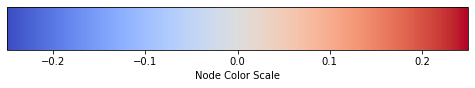

NGLWidget()

In [143]:
cMap=matplotlib.cm.get_cmap('coolwarm',256)
cNorm=matplotlib.colors.Normalize(-.25,.25)
colorVals=plotData.RelativeDelta.to_list()*6
colorList=[
    x.replace('#','0x') for x in \
    map(matplotlib.colors.to_hex,
        cMap(cNorm(
                colorVals
             )))]

correlation_data_utilities.drawEdgeColorBar(
     np.array([colorVals]),maskInds=None,
     cmap=cMap,
     cNorm=cNorm,
     ax=None,
     label='Node Color Scale',
     orientation='horizontal',
     verbose=False)
view=nv.show_pytraj(viewStruc)
view.clear_representations()
view.add_cartoon('protein')
view._set_color_by_residue(colorList)
for resid in sourceResids+1:
    view.add_representation('spacefill',selection='%g'%resid,alpha=.5)
for resid in targetResids+1:
    view.add_representation('spacefill',selection='%g'%resid,alpha=.5)
display(view)

In [128]:
plotData.RelativeDelta.to_list()*6

[-0.2202656880809583,
 -0.2667178763968576,
 -0.1895331199423362,
 -0.19106286186284505,
 -0.16573038711052518,
 -0.11148865971740758,
 -0.27899429185254604,
 -0.239451937306457,
 -0.0667051349985506,
 -0.07055747708740281,
 -0.063279896074848,
 -0.03783102204042387,
 0.01940875388333386,
 -0.020725216602711653,
 -0.013690121218707198,
 0.07805160024307137,
 -0.05485697700190687,
 -0.07598113986611509,
 -0.14825438430481497,
 -0.25540740920081895,
 -0.27942665239895226,
 -0.005695549209717436,
 -0.026635836069200013,
 -0.046603379756360155,
 -0.08764779732780355,
 -0.056410765453687194,
 -0.04180106291655817,
 -0.055071827700411226,
 -0.0024727964218805264,
 -0.06977083920835118,
 -0.062101502590746586,
 -0.045528711725801904,
 0.0043889886402737974,
 0.02559231152740523,
 -0.035873939433475485,
 -0.005024097004240323,
 -0.03741521180739303,
 -0.05610006014494942,
 -0.031107630127739545,
 -0.02198920723627611,
 -0.05432721573978841,
 -0.06834314651132276,
 -0.03066929266372874,
 -0.031